<a href="https://colab.research.google.com/github/RicardColomOrero/easymoney/blob/eva/Easymoney_grupo5_2906_pivot%20table_val_reducido.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ENUNCIADO CAPSTONE


## 1.- PowerBI (Opcional)
Hemos decidido reorientar nuestra estrategia comercial hacia el
**aumento de la penetración de la cartera actual de productos en nuestro mercado**, con la idea de obtener una
mejor rentabilidad de nuestra base actual de clientes (lo del cuadrante barato de la matriz de Ansoff).

A cambio, reduciremos la actividad intensiva de captación que veníamos realizando desde que arrancamos. En este sentido, y para acabar de definir la estrategia, estaría genial poder tener algunos análisis que nos ayuden
a tomar decisiones. Como te decía, ahora tenemos un autoservicio, pero esta foto simple no nos ayuda demasiado.
Si ni siquiera sé cuantos productos hemos vendido este mes o si son los clientes nuevos quiénes contratan o los que ya teníamos!

Sería genial incluso que pudieses utilizar el reciente producto adquirido
PowerBI para **preparar unos KPI’s de lo que tenemos en la empresa**

## 2.- Propensión (modelo de propensión a compra)

Una vez que hayamos hecho el **análisis de nuestra BBDD nos gustaría poder vender más y mejor nuestros productos**, sé que los data scientist tienen una “bola de cristal” y saben qué clientes son más propensos a
comprar nuestros productos así que te pido por favor hagas un **modelo de propensión a compra**, se que tenemos muchos productos, así que te **,dejo a tu criterio científico qué productos elegir, o pueden ser varios,**, ya
me sorprenderás

## 3.- Segmentación

Una vez obtenido la propensión de los productos sería genial poder conocer mejor a nuestros clientes para orientar nuestra actividad comercial. Hace tiempo vengo teniendo la idea de que podríamos **segmentar la base
de clientes en 7 u 8 grupos de clientes similares**... sería genial** identificarlos, y poder saber cómo son los clientes
que pertenecen a estos grupos**... nos ayudaría muchísimo a la hora de definir todo nuestro plan de marketing de cara a futuro!

## 4.- Caso de uso

Perfecto! Tenemos las segmentaciones de clientes, tenemos las propensiones y ahora lo que nos falta es realizar
**un caso de uso que nos permita estimar en base a una campaña X cuánto dinero podemos ganar**,

¿A cuántos clientes tenemos que impactar?

¿Qué productos ofrecer?

¿Impactamos a todos lo segmentos indicados?

**Restricción de 10.000 clientes para la campaña.**

# Importación de librerías

In [2]:
import numpy as np # Arrays
import pandas as pd # Series and Dataframes

from google.colab import files

#visualizacion
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 200
plt.style.use('ggplot') # Beautify Plots

#Modelling
from sklearn import model_selection
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importación dataset

In [5]:
#file_dir = "/content/drive/MyDrive/NUCLIO/TFM  Data Science/datasets_TFM_y_diccionario/" #Ricard file_dir
file_dir = "/content/drive/MyDrive/TFM  Data Science/datasets_TFM_y_diccionario/" #Eva file_dir
#file_dir = "/content/drive/MyDrive/Master_DS/TFM_Data_Science/datasets_TFM_y_diccionario/" #Culebra file_dir

In [6]:
file_sales ="sales.csv"
file_product_description ="product_description.csv"
file_customer_sociodemographics ="customer_sociodemographics.csv"
file_customer_commercial_activity = "customer_commercial_activity.csv"
file_customer_products ="customer_products.csv"
file_provincias = "inform_adicional_por_provincias.csv"

In [7]:
sales_raw = pd.read_csv(file_dir + file_sales)
product_description_raw = pd.read_csv(file_dir +file_product_description)
customer_sociodemographics_raw = pd.read_csv(file_dir + file_customer_sociodemographics)
customer_commercial_activity_raw = pd.read_csv(file_dir + file_customer_commercial_activity)
customer_products_raw = pd.read_csv(file_dir + file_customer_products)

In [8]:
info_provincias_raw = pd.read_csv(file_dir + file_provincias)

# 2.- DATA UNDERSTANDING

In [9]:
def report_df(df, verbose = True):
    '''
    Hace un report simple sobre el DataFrame suministrado.
    '''
    print("***INFO***")
    print(df.info(verbose = verbose))

    print("***DESCRIPTIVOS CATEGORICAS***")
    try:
      print(df.describe(include = ['object']))
    except:
          print("Oops!  No hay variables categóricas")

    print("***DESCRIPTIVOS NUMÉRICAS***")
    try:
      print(df.describe(exclude = ['object']))
    except:
          print("Oops!  No hay variables categóricas")

    print("***NULOS***")
    total_nulos = df.isnull().sum().sum()
    print(df.isnull().sum())
    print(f"Tenemos un total de {total_nulos} nulos")

### Sales

* pk_sale: Identificador de venta - (primary key)
* cid: Identificador de cliente - (foreing key)
* month_sale: Mes de venta. Mes en el que se contrata un producto.
* product_ID: Identificador de producto  - (foreing key)
* net_margin: Margen neto generado por la venta ($)

In [10]:
# Análisis inicial de sales

report_df(sales_raw)

***INFO***
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240773 entries, 0 to 240772
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  240773 non-null  int64  
 1   pk_sale     240773 non-null  int64  
 2   cid         240773 non-null  int64  
 3   month_sale  240773 non-null  object 
 4   product_ID  240773 non-null  int64  
 5   net_margin  240773 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 11.0+ MB
None
***DESCRIPTIVOS CATEGORICAS***
        month_sale
count       240773
unique          16
top     2018-10-01
freq         27693
***DESCRIPTIVOS NUMÉRICAS***
          Unnamed: 0        pk_sale           cid     product_ID  \
count  240773.000000  240773.000000  2.407730e+05  240773.000000   
mean   120386.000000  127052.000000  1.363934e+06    3945.408202   
std     69505.322519   69505.322519  1.751721e+05    1632.821700   
min         0.000000    6666.000000  1.589100e+0

In [ ]:
# ACCIONES A LLEVAR A CABO

# Eliminar columna Unnamed
# Renombrar columnas para alinear el naming, por ejemplo variable cid como "client_ID", pk_sale como "sale_ID"
# Cambiar los identificadores (product_ID, customer_ID) a variable categórica
# Cambiar tipo de month_sale a fecha
# Disgregar la fecha en mes, año... (otros: trimestre, fin de semana, festivo...)


### Product Description

* pk_product_ID	= Identificador de producto - (primary key)
* product_desc	= Descripción del producto
* family_product	= Vertical del producto. Grupo al que pertenece.

In [11]:
# Análisis inicial de product description

report_df(product_description_raw)

***INFO***
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      13 non-null     int64 
 1   pk_product_ID   13 non-null     int64 
 2   product_desc    13 non-null     object
 3   family_product  13 non-null     object
dtypes: int64(2), object(2)
memory usage: 544.0+ bytes
None
***DESCRIPTIVOS CATEGORICAS***
       product_desc family_product
count            13             13
unique           13              5
top       em_acount        account
freq              1              4
***DESCRIPTIVOS NUMÉRICAS***
       Unnamed: 0  pk_product_ID
count    13.00000      13.000000
mean      6.00000    3614.538462
std       3.89444    2564.251438
min       0.00000    1119.000000
25%       3.00000    2235.000000
50%       6.00000    2336.000000
75%       9.00000    4033.000000
max      12.00000    9001.000000
***NULOS***
Unnamed: 0        0

In [ ]:
# ACCIONES A LLEVAR A CABO

# Eliminar columna Unnamed

### Customer Sociodemographics

* pk_cid =	Identificador de cliente
* pk_partition =	Identificador de Partición. Mensualmente se ingesta en la tabla una partición con el estado de la base de clientes.
* deceased =	Indicador de fallecimiento
* gender =	Sexo del cliente
* region_code =	Provincia de residencia del cliente (para ES)
* salary =	Ingresos brutos de la unidad familiar
* country_id =	País de residencia del cliente
* age =	Edad del cliente

In [12]:
report_df(customer_sociodemographics_raw)

***INFO***
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 9 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Unnamed: 0    int64  
 1   pk_cid        int64  
 2   pk_partition  object 
 3   country_id    object 
 4   region_code   float64
 5   gender        object 
 6   age           int64  
 7   deceased      object 
 8   salary        float64
dtypes: float64(2), int64(3), object(4)
memory usage: 409.4+ MB
None
***DESCRIPTIVOS CATEGORICAS***
       pk_partition country_id   gender deceased
count       5962924    5962924  5962899  5962924
unique           17         41        2        2
top         2019-05         ES        H        N
freq         442995    5960672  3087502  5961849
***DESCRIPTIVOS NUMÉRICAS***
         Unnamed: 0        pk_cid   region_code           age        salary
count  5.962924e+06  5.962924e+06  5.960660e+06  5.962924e+06  4.421820e+06
mean   7.155425e+06  1.234930e+06  2.581440e+01  2.976

In [13]:
customer_sociodemographics_raw["country_id"].value_counts(normalize = True).head()

ES    0.999622
GB    0.000074
FR    0.000038
DE    0.000033
US    0.000033
Name: country_id, dtype: float64

In [14]:
customer_sociodemographics_raw["region_code"].value_counts()

28.0    1185757
8.0      600362
46.0     358142
30.0     296856
41.0     290447
15.0     254891
29.0     187911
36.0     175850
3.0      171358
11.0     160894
33.0     134562
50.0     132983
6.0      122587
35.0     121982
47.0     116948
18.0     102789
45.0     102328
37.0      92538
10.0      83283
14.0      75405
2.0       72071
21.0      72037
13.0      70092
39.0      69589
12.0      68709
7.0       62436
32.0      54639
27.0      52783
43.0      51782
17.0      50749
9.0       47746
25.0      46887
16.0      36094
24.0      35426
48.0      35256
26.0      34790
4.0       32680
31.0      31241
49.0      30965
23.0      30955
38.0      29001
34.0      27545
19.0      26762
40.0      21658
5.0       21300
22.0      21112
20.0      18833
1.0       12999
44.0      12616
42.0       8500
51.0       2896
52.0       2638
Name: region_code, dtype: int64

In [ ]:
# ACCIONES CUSTOMER SOCIODEMOGRAPHICS

# Gestionar nulos: (Culebra: tenemos modelo de clasificación así que lo que haremos será ponerles valores extremos)
#     region_code
#     gender
#     salary
# gender > Transformar a 1 y 0
# deceased > Transformar a 1 y 0
# country_id > Agrupar ES, OTHERS



### Customer Commercial Activity

* pk_cid = Identificador de cliente
* pk_partition =	Identificador de Partición. Mensualmente se ingesta en la tabla una partición con el estado de la base de clientes.
* entry_channel =	Canal de captación del cliente
* entry_date =	Fecha en la que realizó la primera contratación a través de easyMoney
* segment =	Segmento comercial del cliente
* active_customer =	Indicador de actividad del cliente en la app EasyMoney

In [15]:
report_df(customer_commercial_activity_raw)

***INFO***
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 7 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Unnamed: 0       int64  
 1   pk_cid           int64  
 2   pk_partition     object 
 3   entry_date       object 
 4   entry_channel    object 
 5   active_customer  float64
 6   segment          object 
dtypes: float64(1), int64(2), object(4)
memory usage: 318.5+ MB
None
***DESCRIPTIVOS CATEGORICAS***
       pk_partition entry_date entry_channel             segment
count       5962924    5962924       5829891             5828980
unique           17         53            68                   3
top         2019-05    2016-10           KHE  03 - UNIVERSITARIO
freq         442995     382473       3113947             3900166
***DESCRIPTIVOS NUMÉRICAS***
         Unnamed: 0        pk_cid  active_customer
count  5.962924e+06  5.962924e+06     5.962924e+06
mean   7.155425e+06  1.234930e+06     4.033845e-01


In [16]:
customer_commercial_activity_raw["segment"].value_counts()

03 - UNIVERSITARIO    3900166
02 - PARTICULARES     1830875
01 - TOP                97939
Name: segment, dtype: int64

In [17]:
customer_commercial_activity_raw["entry_channel"].value_counts(normalize = True).head(10)

KHE    0.534135
KFC    0.152768
KHQ    0.101251
KAT    0.071371
KHK    0.039486
KHM    0.030291
KHN    0.018600
KFA    0.013554
KHD    0.013019
RED    0.010395
Name: entry_channel, dtype: float64

In [ ]:
# ACCIONES CUSTOMER COMMERCIAL ACTIVITY**


# Eliminar columna Unnamed
# Cambiar los identificadores (pk_cid) a variable categórica
# Cambiar tipo de active_customer a boolean
# Establecer primary key como index?
# Gestionar nulos:
#     entry_channel
#     segment
# Cambiar tipo de entry_date a fecha
# Disgregar entry_date en mes, año, día, día de la semana (otros: trimestre, fin de semana, festivo...)
# entry_channel > OneHotEncoding o FrecuencyEncoding ( agrupar 11-12 etiquetas + OTHERS)
# segment > OneHotEncoding

### Customer Products

- pk_cid =	Identificador de cliente
- pk_partition =	Identificador de Partición. Mensualmente se ingesta en la tabla una partición con el estado de la base de clientes.
- credit_card =	Tenencia de tarjetas de crédito
- debit_card =	Tenencia de tarjetas de débito
- em_account_p =	Tenencia de Cuenta easyMoney+
- em_account_pp =	Tenencia de Cuenta easyMoney++
- em_acount =	Tenencia de Cuenta easyMoney
- emc_account =	Tenencia de Cuenta easyMoney Crypto
- funds =	Tenencia de Fondos de inversión
- loans =	Tenencia de Préstamos
- long_term_deposit =	Tenencia de Depósitos a largo plazo
- mortgage =	Tenencia de Mortgage
- payroll =	Tenencia de Domiciliaciones
- payroll_account =	Tenencia de Cuenta bonificada por domiciliaciones
- pension_plan =	Tenencia de Plan de pensiones
- securities =	Tenencia de Valores
- short_term_deposit =	Tenencia de Short-term deposits

In [18]:
report_df(customer_products_raw)

***INFO***
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 18 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Unnamed: 0          int64  
 1   pk_cid              int64  
 2   pk_partition        object 
 3   short_term_deposit  int64  
 4   loans               int64  
 5   mortgage            int64  
 6   funds               int64  
 7   securities          int64  
 8   long_term_deposit   int64  
 9   em_account_pp       int64  
 10  credit_card         int64  
 11  payroll             float64
 12  pension_plan        float64
 13  payroll_account     int64  
 14  emc_account         int64  
 15  debit_card          int64  
 16  em_account_p        int64  
 17  em_acount           int64  
dtypes: float64(2), int64(15), object(1)
memory usage: 818.9+ MB
None
***DESCRIPTIVOS CATEGORICAS***
       pk_partition
count       5962924
unique           17
top         2019-05
freq         442995
***DESCRIPTIVOS

In [ ]:
# ACCIONES CUSTOMER PRODUCTS

# Eliminar columna Unnamed
# Cambiar los identificadores (pk_cid) a variable categórica
# Cambiar tipo de columnas booleanas a boolean?
# Establecer primary key como index?
# Gestionar nulos:
#     payroll
#     pension_plan
# Eliminar em_account_pp, no hay datos

# Cambiar tipo de payroll y pension_plan a int

### Análisis del target

In [ ]:
# Para el modelo de propensión a compra (supervisado > clasificación) trataremos de averiguar la propensión a compra de ciertos productos de cada cliente
# El target puede ser:
#  - em_acount = 4.381.602  (73,48%)
#  - debit_card = 562.968 (9,44%)
#  - payroll_account = 329.420 (5,52%)
#  - pension_plan = 2.178.020 (3,65%) ** Target interesante por negocio



# Analizando el revenue de cada producto:
#  - pension_plan = media >5200€ ** Target interesante por revenue
#  - loans = media > 2000€
#  - mortgage = media > 2000€
#
#
# El producto "pension_plan" resulta interesante a nivel net margin, pues es el que más beneficios genera a la compañía

# Hecho el primero modelo para "pension plan", más tarde se puede volver a lanzar con otros target de interés, por ejemplo "debit_card"o "emc_account "


TARGET = "pension_plan"
TARGET2 = 'debit_card'
TARGET3 = 'emc_account'

In [19]:
for i in ['short_term_deposit', 'loans', 'mortgage', 'funds', 'securities','long_term_deposit', 'em_account_pp','credit_card', 'payroll', 'pension_plan', 'payroll_account','emc_account', 'debit_card', 'em_account_p', 'em_acount']:
    suma_productos = customer_products_raw[i].sum()
    print (f"Suma de {i} = {suma_productos} . La media es de {round((suma_productos/customer_products_raw.shape[0])*100,2)}%")


Suma de short_term_deposit = 15394 . La media es de 0.26%
Suma de loans = 468 . La media es de 0.01%
Suma de mortgage = 324 . La media es de 0.01%
Suma de funds = 20099 . La media es de 0.34%
Suma de securities = 22133 . La media es de 0.37%
Suma de long_term_deposit = 100660 . La media es de 1.69%
Suma de em_account_pp = 0 . La media es de 0.0%
Suma de credit_card = 70866 . La media es de 1.19%
Suma de payroll = 205787.0 . La media es de 3.45%
Suma de pension_plan = 217802.0 . La media es de 3.65%
Suma de payroll_account = 329420 . La media es de 5.52%
Suma de emc_account = 326961 . La media es de 5.48%
Suma de debit_card = 562968 . La media es de 9.44%
Suma de em_account_p = 34 . La media es de 0.0%
Suma de em_acount = 4381602 . La media es de 73.48%


### Distribución de las variables

#### Variables numéricas

In [20]:
for i in sales_raw.select_dtypes(include= ["number"]).columns:
     print(i, sales_raw[i].value_counts())

Unnamed: 0 0         1
160520    1
160508    1
160509    1
160510    1
         ..
80262     1
80263     1
80264     1
80265     1
240772    1
Name: Unnamed: 0, Length: 240773, dtype: int64
pk_sale 6666      1
167186    1
167174    1
167175    1
167176    1
         ..
86928     1
86929     1
86930     1
86931     1
247438    1
Name: pk_sale, Length: 240773, dtype: int64
cid 1387215    10
1436512     9
1380507     9
1402957     9
1402199     9
           ..
1409414     1
1409413     1
1409412     1
1409410     1
1553571     1
Name: cid, Length: 152754, dtype: int64
product_ID 4657    117435
3819     38840
1364     19369
2234     18750
2235     18110
8871     12323
2312      5206
2335      4441
2336      4227
2673      1157
1119       880
9001        25
4033        10
Name: product_ID, dtype: int64
net_margin 63.1       890
64.8       854
63.9       851
64.1       848
62.7       841
          ... 
4917.3       1
5698.9       1
5708.1       1
11009.5      1
34.5         1
Name: net_margi

In [21]:
for i in customer_products_raw.select_dtypes(include= ["number"]).columns:
  print(i, customer_products_raw[i].value_counts())

Unnamed: 0 0           1
9344701     1
9344699     1
9344698     1
9344697     1
           ..
5074084     1
5074083     1
5074082     1
5074081     1
13647308    1
Name: Unnamed: 0, Length: 5962924, dtype: int64
pk_cid 1375586    17
1328781    17
1328783    17
1328784    17
1328786    17
           ..
1521045     1
1545224     1
1470941     1
1521049     1
1550586     1
Name: pk_cid, Length: 456373, dtype: int64
short_term_deposit 0    5947530
1      15394
Name: short_term_deposit, dtype: int64
loans 0    5962456
1        468
Name: loans, dtype: int64
mortgage 0    5962600
1        324
Name: mortgage, dtype: int64
funds 0    5942825
1      20099
Name: funds, dtype: int64
securities 0    5940791
1      22133
Name: securities, dtype: int64
long_term_deposit 0    5862264
1     100660
Name: long_term_deposit, dtype: int64
em_account_pp 0    5962924
Name: em_account_pp, dtype: int64
credit_card 0    5892058
1      70866
Name: credit_card, dtype: int64
payroll 0.0    5757076
1.0     205787


In [22]:
for i in customer_sociodemographics_raw.select_dtypes(include= ["number"]).columns:
     print(i, customer_sociodemographics_raw[i].value_counts())

Unnamed: 0 0           1
9344701     1
9344699     1
9344698     1
9344697     1
           ..
5074084     1
5074083     1
5074082     1
5074081     1
13647308    1
Name: Unnamed: 0, Length: 5962924, dtype: int64
pk_cid 1375586    17
1328781    17
1328783    17
1328784    17
1328786    17
           ..
1521045     1
1545224     1
1470941     1
1521049     1
1550586     1
Name: pk_cid, Length: 456373, dtype: int64
region_code 28.0    1185757
8.0      600362
46.0     358142
30.0     296856
41.0     290447
15.0     254891
29.0     187911
36.0     175850
3.0      171358
11.0     160894
33.0     134562
50.0     132983
6.0      122587
35.0     121982
47.0     116948
18.0     102789
45.0     102328
37.0      92538
10.0      83283
14.0      75405
2.0       72071
21.0      72037
13.0      70092
39.0      69589
12.0      68709
7.0       62436
32.0      54639
27.0      52783
43.0      51782
17.0      50749
9.0       47746
25.0      46887
16.0      36094
24.0      35426
48.0      35256
26.0      3

#### Variables categóricas

In [23]:
for i in sales_raw.select_dtypes(exclude= ["number"]).columns:
     print(i, sales_raw[i].value_counts())

month_sale 2018-10-01    27693
2018-09-01    24488
2018-08-01    21054
2018-07-01    20602
2018-11-01    19155
2018-02-01    15182
2018-12-01    15015
2019-01-01    11872
2018-03-01    11668
2018-06-01    11558
2019-03-01    11506
2019-02-01    11360
2019-05-01    10211
2018-04-01     9962
2019-04-01     9889
2018-05-01     9558
Name: month_sale, dtype: int64


In [24]:
for i in customer_commercial_activity_raw.select_dtypes(exclude= ["number"]).columns:
  print(i, customer_commercial_activity_raw[i].value_counts())

pk_partition 2019-05    442995
2019-04    439627
2019-03    436183
2019-02    431727
2019-01    426875
2018-12    422481
2018-11    416387
2018-10    402300
2018-09    375323
2018-08    352922
2018-07    339339
2018-06    252104
2018-05    249926
2018-04    247463
2018-03    245258
2018-02    242521
2018-01    239493
Name: pk_partition, dtype: int64
entry_date 2016-10    382473
2017-10    340613
2015-10    310295
2017-09    294752
2017-07    267173
2016-08    252704
2015-08    221984
2015-07    220941
2017-11    217751
2015-09    217174
2018-10    216947
2015-11    210687
2016-09    206107
2018-09    202262
2016-07    189225
2016-11    188601
2018-07    178215
2017-08    162534
2018-08    138420
2017-12    123456
2018-11    103073
2016-12     89423
2015-12     82347
2017-01     65539
2018-02     61283
2018-01     59721
2017-06     54925
2018-03     51022
2016-01     50830
2017-02     50561
2017-03     50268
2017-05     50165
2017-04     47729
2018-04     43480
2018-12     41244
2018-05

In [25]:
for i in customer_sociodemographics_raw.select_dtypes(exclude= ["number"]).columns:
  print(i, customer_sociodemographics_raw[i].value_counts())

pk_partition 2019-05    442995
2019-04    439627
2019-03    436183
2019-02    431727
2019-01    426875
2018-12    422481
2018-11    416387
2018-10    402300
2018-09    375323
2018-08    352922
2018-07    339339
2018-06    252104
2018-05    249926
2018-04    247463
2018-03    245258
2018-02    242521
2018-01    239493
Name: pk_partition, dtype: int64
country_id ES    5960672
GB        441
FR        225
DE        199
US        195
CH        194
BR         87
BE         81
VE         79
IE         68
MX         58
AT         51
AR         51
PL         49
IT         45
MA         34
CL         30
CN         28
CA         22
LU         17
ET         17
QA         17
CI         17
SA         17
CM         17
SN         17
MR         17
NO         17
RU         17
CO         17
GA         17
GT         17
DO         17
SE         16
DJ         11
PT         11
JM         11
RO          9
HU          8
DZ          7
PE          4
Name: country_id, dtype: int64
gender H    3087502
V    2875397

# 3.- PRE PROCESSING

In [26]:
def preprocesado_basico(df, cid="pk_cid"):
  # Eliminar columna Unnamed
  df.drop("Unnamed: 0", axis = 1, inplace = True)

  # Renombrar columnas para alinear el naming
  df.rename({cid: "customer_ID",'pk_partition':'partition_ID' },axis='columns',inplace = True)

  # Cambiar a fecha la partition ID
  df['partition_ID'] = pd.to_datetime(df['partition_ID'])

In [27]:
def setOthers(dataframe, column, num_values=5):
    top_categories = dataframe[column].value_counts().head(num_values)
    top_categories_list = top_categories.index.to_list()
    top_categories_list.append('OTHERS')
    dataframe[column] = pd.Categorical(dataframe[column], categories=top_categories_list)
    return dataframe[column].fillna('OTHERS')

In [28]:
def comprobar_shapes(df1,df2,df_final):
  print("DF1 = " + str(df1.shape))
  print("DF2 = " + str(df2.shape))
  print("DF_final = " + str(df_final.shape))

## Sales

In [104]:
df_sales1 = sales_raw.copy()

In [105]:
# Eliminar columna Unnamed
df_sales1.drop("Unnamed: 0", axis = 1, inplace = True)

In [106]:
# Renombrar columnas para alinear el naming
df_sales1.rename({"cid": "customer_ID",'pk_partition':'partition_ID' },axis='columns',inplace = True)

In [107]:
#elimnar todas excepto,  month_sale, customer_id, y product_ID
df_sales1.drop("pk_sale", axis = 1, inplace = True)
df_sales1.drop("net_margin", axis = 1, inplace = True)

In [108]:
# Cambiar los identificadores (product_ID, customer_ID) a variable categórica
df_sales1["product_ID"] = df_sales1["product_ID"].astype("object")
df_sales1["customer_ID"] = df_sales1["customer_ID"].astype("object")

In [109]:
# Cambiar tipo de month_sale a fecha

df_sales1["month_sale"] = pd.to_datetime(df_sales1["month_sale"], format = "%Y/%m/%d")

# Cambiar tipo de customer_ID a número

df_sales1['customer_ID']=df_sales1['customer_ID'].astype('int')

In [110]:
df_sales1['merge_date']=df_sales1['month_sale']+pd.DateOffset(months=1)

In [ ]:
# Disgregar la fecha en mes, año, día, día de la semana (otros: trimestre, fin de semana, festivo...)

#df_sales1["month_sales"] = df_sales1["month_sale"].dt.month
#df_sales1["year_sales"] = df_sales1["month_sale"].dt.year

In [112]:
df_sales1.head()

,customer_ID,month_sale,product_ID,merge_date
0,33620,2018-05-01,2335,2018-06-01
1,35063,2018-06-01,2335,2018-07-01
2,37299,2018-02-01,2335,2018-03-01
3,39997,2018-02-01,2335,2018-03-01
4,44012,2018-02-01,2335,2018-03-01


In [113]:
report_df(df_sales1)

***INFO***
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240773 entries, 0 to 240772
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   customer_ID  240773 non-null  int64         
 1   month_sale   240773 non-null  datetime64[ns]
 2   product_ID   240773 non-null  object        
 3   merge_date   240773 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 7.3+ MB
None
***DESCRIPTIVOS CATEGORICAS***
        product_ID
count       240773
unique          13
top           4657
freq        117435
***DESCRIPTIVOS NUMÉRICAS***
         customer_ID           month_sale           merge_date
count   2.407730e+05               240773               240773
unique           NaN                   16                   16
top              NaN  2018-10-01 00:00:00  2018-11-01 00:00:00
freq             NaN                27693                27693
first            NaN  2018-02-01 00

<ipython-input-9-0319c75cb06a>:16: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(df.describe(exclude = ['object']))
<ipython-input-9-0319c75cb06a>:16: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(df.describe(exclude = ['object']))


## Product Description

In [114]:
product_description_1 = product_description_raw.copy()

In [115]:
# Eliminar columna Unnamed
product_description_1.drop("Unnamed: 0", axis = 1, inplace = True)

In [116]:
report_df(product_description_1)

***INFO***
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   pk_product_ID   13 non-null     int64 
 1   product_desc    13 non-null     object
 2   family_product  13 non-null     object
dtypes: int64(1), object(2)
memory usage: 440.0+ bytes
None
***DESCRIPTIVOS CATEGORICAS***
       product_desc family_product
count            13             13
unique           13              5
top       em_acount        account
freq              1              4
***DESCRIPTIVOS NUMÉRICAS***
       pk_product_ID
count      13.000000
mean     3614.538462
std      2564.251438
min      1119.000000
25%      2235.000000
50%      2336.000000
75%      4033.000000
max      9001.000000
***NULOS***
pk_product_ID     0
product_desc      0
family_product    0
dtype: int64
Tenemos un total de 0 nulos


## Customer Sociodemographics

In [117]:
#hacemos una copia del dataset par eliminar los deceased yes
df_customer_soc1 = customer_sociodemographics_raw[customer_sociodemographics_raw['deceased']=='N'].copy()

In [118]:
preprocesado_basico(df_customer_soc1)

In [119]:
df_customer_soc1.drop("deceased", axis = 1, inplace = True)

Gestión de nulos

In [120]:
# Asignamos valor extremos a "salary", "gender", "region_code" ya que vamos a hacer un DecisionTree

print(df_customer_soc1["salary"].describe())
df_customer_soc1["salary"].fillna(value = 0, inplace = True)

print(df_customer_soc1["gender"].value_counts(normalize = True))
df_customer_soc1["gender"].fillna(value = 2, inplace = True)

print(df_customer_soc1["region_code"].describe())
df_customer_soc1["region_code"].fillna(value = 1000, inplace = True)

count    4.420973e+06
mean     1.155814e+05
std      2.000178e+05
min      1.202730e+03
25%      6.141360e+04
50%      8.843820e+04
75%      1.313081e+05
max      2.889440e+07
Name: salary, dtype: float64
H    0.517818
V    0.482182
Name: gender, dtype: float64
count    5.959590e+06
mean     2.581401e+01
std      1.359580e+01
min      1.000000e+00
25%      1.300000e+01
50%      2.800000e+01
75%      3.600000e+01
max      5.200000e+01
Name: region_code, dtype: float64


Agrupación

In [121]:
#agrupamos country_id en ES y OTHERS
print((df_customer_soc1["country_id"].value_counts(normalize=True)*100).head())

df_customer_soc1['country_id'] = setOthers(df_customer_soc1,'country_id',num_values=1)

print()
print((df_customer_soc1["country_id"].value_counts(normalize=True)*100).head())

#df1.drop("country_id", axis = 1, inplace = True)

ES    99.962310
GB     0.007397
FR     0.003774
DE     0.003338
US     0.003271
Name: country_id, dtype: float64

ES        99.96231
OTHERS     0.03769
Name: country_id, dtype: float64


In [122]:
df_customer_soc1.head()

,customer_ID,partition_ID,country_id,region_code,gender,age,salary
0,1375586,2018-01-01,ES,29.0,H,35,87218.10
1,1050611,2018-01-01,ES,13.0,V,23,35548.74
2,1050612,2018-01-01,ES,13.0,V,23,122179.11
3,1050613,2018-01-01,ES,50.0,H,22,119775.54
4,1050614,2018-01-01,ES,50.0,V,23,0.00


In [123]:
report_df(df_customer_soc1)

***INFO***
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5961849 entries, 0 to 5962923
Data columns (total 7 columns):
 #   Column        Dtype         
---  ------        -----         
 0   customer_ID   int64         
 1   partition_ID  datetime64[ns]
 2   country_id    category      
 3   region_code   float64       
 4   gender        object        
 5   age           int64         
 6   salary        float64       
dtypes: category(1), datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 324.1+ MB
None
***DESCRIPTIVOS CATEGORICAS***
         gender
count   5961849
unique        3
top           H
freq    3087137
***DESCRIPTIVOS NUMÉRICAS***


<ipython-input-9-0319c75cb06a>:16: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(df.describe(exclude = ['object']))


         customer_ID         partition_ID country_id   region_code  \
count   5.961849e+06              5961849    5961849  5.961849e+06   
unique           NaN                   17          2           NaN   
top              NaN  2019-05-01 00:00:00         ES           NaN   
freq             NaN               442909    5959602           NaN   
first            NaN  2018-01-01 00:00:00        NaN           NaN   
last             NaN  2019-05-01 00:00:00        NaN           NaN   
mean    1.234946e+06                  NaN        NaN  2.618314e+01   
std     1.622883e+05                  NaN        NaN  2.332893e+01   
min     1.589100e+04                  NaN        NaN  1.000000e+00   
25%     1.112541e+06                  NaN        NaN  1.300000e+01   
50%     1.231108e+06                  NaN        NaN  2.800000e+01   
75%     1.352348e+06                  NaN        NaN  3.600000e+01   
max     1.553689e+06                  NaN        NaN  1.000000e+03   

                 ag

In [124]:
# Añadimos información de las provincias
df_customer_soc1 = df_customer_soc1.merge(info_provincias_raw, how = "left", left_on = "region_code", right_on = "codigo")

In [125]:
df_customer_soc1.isnull().sum()

customer_ID             0
partition_ID            0
country_id              0
region_code             0
gender                  0
age                     0
salary                  0
provincia            2259
codigo               2259
renta_neta_media     2259
renta_bruta_media    2259
tasa_de_paro         2259
tasa_de_empleo       2259
dtype: int64

In [126]:
del df_customer_soc1["region_code"]
del df_customer_soc1["codigo"]

In [127]:
df_customer_soc1.head()

,customer_ID,partition_ID,country_id,gender,age,salary,provincia,renta_neta_media,renta_bruta_media,tasa_de_paro,tasa_de_empleo
0,1375586,2018-01-01,ES,H,35,87218.10,Málaga,10261.0,15512.0,22.60,44.20
1,1050611,2018-01-01,ES,V,23,35548.74,Ciudad Real,10570.0,11811.0,18.35,44.95
2,1050612,2018-01-01,ES,V,23,122179.11,Ciudad Real,10570.0,11811.0,18.35,44.95
3,1050613,2018-01-01,ES,H,22,119775.54,Zaragoza,13637.0,16156.0,12.24,51.20
4,1050614,2018-01-01,ES,V,23,0.00,Zaragoza,13637.0,16156.0,12.24,51.20


In [128]:
df_customer_soc1["provincia"].fillna(value = "No definido", inplace = True)
df_customer_soc1["renta_neta_media"].fillna(np.mean(df_customer_soc1["renta_neta_media"]), inplace = True)
df_customer_soc1["renta_bruta_media"].fillna(np.mean(df_customer_soc1["renta_bruta_media"]), inplace = True)
df_customer_soc1["tasa_de_paro"].fillna(np.mean(df_customer_soc1["tasa_de_paro"]), inplace = True)
df_customer_soc1["tasa_de_empleo"].fillna(np.mean(df_customer_soc1["tasa_de_empleo"]), inplace = True)

## Customer commercial activity

In [129]:
# La cantidad de clientes inactivos son 317.179
customer_commercial_activity_raw[customer_commercial_activity_raw["active_customer"] == 0]["pk_cid"].nunique()

317179

In [131]:
# Eliminamos los clientes inactivos del dataset al no ser target
df_cust_com_act1 = customer_commercial_activity_raw[customer_commercial_activity_raw['active_customer']==1].copy()

In [132]:
preprocesado_basico(df_cust_com_act1)

In [133]:
# Creamos la variable "Antiguedad" restando la última fecha de partition por el entry_date
df_cust_com_act1['antiguedad']=pd.to_datetime(df_cust_com_act1['partition_ID'].max())-pd.to_datetime(df_cust_com_act1['entry_date'])

In [134]:
df_cust_com_act1['antiguedad']=df_cust_com_act1['antiguedad'].astype(int)/86400000000000

In [135]:
df_cust_com_act1.drop("active_customer", axis = 1, inplace = True)
df_cust_com_act1.drop("entry_date", axis = 1, inplace = True)

Gestión de nulos

In [136]:
# Función para imputar nulos de Segment y Entry Channel

def imputacion_nulos(df,col):
  # Array con los ids que tienen nulos
  ids_null_unique = df[(df[col].isnull()==True)]['customer_ID'].unique()
  # Dataframe donde revisamos si en la última carga de datos hay un valor para los ids que tienen "entry_channel" nulo.
  valores_nulos = df[(df.customer_ID.isin(ids_null_unique))&(df[col].notnull())&(df['partition_ID']== "2019-05")][['customer_ID',col]]
  # Si el id con "entry_channel" nulo tenía un valor correcto en la última partition, se lo asignaremos a los valores nulos.
  dict_nulos = dict(zip(valores_nulos['customer_ID'],valores_nulos[col]))
  df.set_index('customer_ID',inplace = True)
  # Imputamos los últimos valores registrados correctamente en "segment" y "entry_channel"
  df[col].fillna(dict_nulos,inplace=True)
  df.reset_index(inplace = True)

In [137]:
imputacion_nulos(df_cust_com_act1,col = 'segment')

In [138]:
imputacion_nulos(df_cust_com_act1,col = 'entry_channel')

In [139]:
# Imputación de valores extremos a los nulos que no se han podido deducir por el histórico
df_cust_com_act1['segment'].fillna(value='04 - NO SEGMENT',inplace=True)
df_cust_com_act1['entry_channel'].fillna(value='ZZZ',inplace=True)

Agrupación

In [140]:
df_cust_com_act1['entry_channel']=setOthers(df_cust_com_act1,'entry_channel',num_values=13)

In [141]:
df_cust_com_act1.head()

,customer_ID,partition_ID,entry_channel,segment,antiguedad
0,1375586,2018-01-01,KHL,02 - PARTICULARES,485.0
1,1050614,2018-01-01,KHE,03 - UNIVERSITARIO,1369.0
2,1050617,2018-01-01,KHE,03 - UNIVERSITARIO,1369.0
3,1050623,2018-01-01,KHE,03 - UNIVERSITARIO,1369.0
4,1050624,2018-01-01,KHE,02 - PARTICULARES,1369.0


In [142]:
report_df(df_cust_com_act1)

***INFO***
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2405351 entries, 0 to 2405350
Data columns (total 5 columns):
 #   Column         Dtype         
---  ------         -----         
 0   customer_ID    int64         
 1   partition_ID   datetime64[ns]
 2   entry_channel  category      
 3   segment        object        
 4   antiguedad     float64       
dtypes: category(1), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 75.7+ MB
None
***DESCRIPTIVOS CATEGORICAS***
                  segment
count             2405351
unique                  4
top     02 - PARTICULARES
freq              1155032
***DESCRIPTIVOS NUMÉRICAS***
         customer_ID         partition_ID entry_channel    antiguedad
count   2.405351e+06              2405351       2405351  2.405351e+06
unique           NaN                   17            14           NaN
top              NaN  2019-05-01 00:00:00           KHE           NaN
freq             NaN               171568        788558       

<ipython-input-9-0319c75cb06a>:16: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(df.describe(exclude = ['object']))


customer_ID      0
partition_ID     0
entry_channel    0
segment          0
antiguedad       0
dtype: int64
Tenemos un total de 0 nulos


## Customer products

In [143]:
df_cust_prod1 = customer_products_raw.copy()

In [144]:
preprocesado_basico(df_cust_prod1)

In [145]:
# Eliminamos el Target de la tabla, lo crearemos a posteriori

df_cust_prod1.drop("pension_plan", axis = 1, inplace = True)

In [146]:
# Eliminamos variables de baja varianza

print(df_cust_prod1["em_account_p"].value_counts(normalize = True)*100)
print(df_cust_prod1["em_account_pp"].value_counts(normalize = True)*100)

del df_cust_prod1['em_account_pp']
del df_cust_prod1['em_account_p']

0    99.99943
1     0.00057
Name: em_account_p, dtype: float64
0    100.0
Name: em_account_pp, dtype: float64


In [147]:
# Eliminamos valores nulos de "payroll"

df_cust_prod1.dropna(subset = ['payroll'], inplace = True)

In [148]:
# Cambiamos el type de las variables con float a int

df_cust_prod1['payroll'] = df_cust_prod1[['payroll']].applymap(int)

In [149]:
df_cust_prod1.head()

,customer_ID,partition_ID,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll,payroll_account,emc_account,debit_card,em_acount
0,1375586,2018-01-01,0,0,0,0,0,0,0,0,0,0,0,1
1,1050611,2018-01-01,0,0,0,0,0,0,0,0,0,0,0,1
2,1050612,2018-01-01,0,0,0,0,0,0,0,0,0,0,0,1
3,1050613,2018-01-01,1,0,0,0,0,0,0,0,0,0,0,0
4,1050614,2018-01-01,0,0,0,0,0,0,0,0,0,0,0,1


In [150]:
report_df(df_cust_prod1)

***INFO***
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5962863 entries, 0 to 5962923
Data columns (total 14 columns):
 #   Column              Dtype         
---  ------              -----         
 0   customer_ID         int64         
 1   partition_ID        datetime64[ns]
 2   short_term_deposit  int64         
 3   loans               int64         
 4   mortgage            int64         
 5   funds               int64         
 6   securities          int64         
 7   long_term_deposit   int64         
 8   credit_card         int64         
 9   payroll             int64         
 10  payroll_account     int64         
 11  emc_account         int64         
 12  debit_card          int64         
 13  em_acount           int64         
dtypes: datetime64[ns](1), int64(13)
memory usage: 682.4 MB
None
***DESCRIPTIVOS CATEGORICAS***
Oops!  No hay variables categóricas
***DESCRIPTIVOS NUMÉRICAS***


<ipython-input-9-0319c75cb06a>:16: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(df.describe(exclude = ['object']))


         customer_ID         partition_ID  short_term_deposit         loans  \
count   5.962863e+06              5962863        5.962863e+06  5.962863e+06   
unique           NaN                   17                 NaN           NaN   
top              NaN  2019-05-01 00:00:00                 NaN           NaN   
freq             NaN               442995                 NaN           NaN   
first            NaN  2018-01-01 00:00:00                 NaN           NaN   
last             NaN  2019-05-01 00:00:00                 NaN           NaN   
mean    1.234930e+06                  NaN        2.581646e-03  7.848579e-05   
std     1.623026e+05                  NaN        5.074427e-02  8.858874e-03   
min     1.589100e+04                  NaN        0.000000e+00  0.000000e+00   
25%     1.112532e+06                  NaN        0.000000e+00  0.000000e+00   
50%     1.231096e+06                  NaN        0.000000e+00  0.000000e+00   
75%     1.352339e+06                  NaN        0.0

## Merge de tablas

###  Customer sociodemographics + Commercial Activity

In [151]:
#Merge de customer_commercial_activity y customer_sociodemografics, customer_products lo dejamos para más tarde
#Hacemos un left join con la tabla customer_commercial activity primero ya que tiene menos filas y son los clientes activos

df1_raw=df_cust_com_act1.merge(df_customer_soc1,how="left", on=["customer_ID","partition_ID"])

In [152]:
df1_raw.head()

,customer_ID,partition_ID,entry_channel,segment,antiguedad,country_id,gender,age,salary,provincia,renta_neta_media,renta_bruta_media,tasa_de_paro,tasa_de_empleo
0,1375586,2018-01-01,KHL,02 - PARTICULARES,485.0,ES,H,35.0,87218.10,Málaga,10261.0,15512.0,22.60,44.20
1,1050614,2018-01-01,KHE,03 - UNIVERSITARIO,1369.0,ES,V,23.0,0.00,Zaragoza,13637.0,16156.0,12.24,51.20
2,1050617,2018-01-01,KHE,03 - UNIVERSITARIO,1369.0,ES,H,23.0,113316.66,Zaragoza,13637.0,16156.0,12.24,51.20
3,1050623,2018-01-01,KHE,03 - UNIVERSITARIO,1369.0,ES,H,23.0,113538.81,Zamora,11737.0,14848.0,13.57,44.16
4,1050624,2018-01-01,KHE,02 - PARTICULARES,1369.0,ES,H,65.0,61605.09,Zaragoza,13637.0,16156.0,12.24,51.20


In [153]:
comprobar_shapes(df_cust_com_act1,df_customer_soc1,df1_raw)

DF1 = (2405351, 5)
DF2 = (5961849, 11)
DF_final = (2405351, 14)


In [154]:
df1_raw.isnull().sum()

customer_ID            0
partition_ID           0
entry_channel          0
segment                0
antiguedad             0
country_id           718
gender               718
age                  718
salary               718
provincia            718
renta_neta_media     718
renta_bruta_media    718
tasa_de_paro         718
tasa_de_empleo       718
dtype: int64

In [155]:
# Los 718 nulos son los deceased que todavía estaban activos. Los eliminamos por no ser target
df1_raw.dropna(inplace = True)

### '+Sales

In [ ]:
#hago merge de df_sales_1 que tiene 240773 filas ( son todas las compras) con la tabla df1 que es la información de clientes a fecha de venta con la partitio_ID de la table df1.
#la fecha merge_date la utilizaré para mergear con la tabla de customer_products proque quiero la información de un mes después para que el modelo prediga mejor

In [156]:
df_total1 = df_sales1.merge(df1_raw, how = "left", left_on= ['customer_ID',"month_sale"], right_on = ['customer_ID', 'partition_ID'])

In [157]:
comprobar_shapes(df_sales1,df1_raw,df_total1)

DF1 = (240773, 4)
DF2 = (2404633, 14)
DF_final = (240773, 17)


In [158]:
df_sales1.head()

,customer_ID,month_sale,product_ID,merge_date
0,33620,2018-05-01,2335,2018-06-01
1,35063,2018-06-01,2335,2018-07-01
2,37299,2018-02-01,2335,2018-03-01
3,39997,2018-02-01,2335,2018-03-01
4,44012,2018-02-01,2335,2018-03-01


In [159]:
df_total1.isnull().sum()

customer_ID              0
month_sale               0
product_ID               0
merge_date               0
partition_ID         48917
entry_channel        48917
segment              48917
antiguedad           48917
country_id           48917
gender               48917
age                  48917
salary               48917
provincia            48917
renta_neta_media     48917
renta_bruta_media    48917
tasa_de_paro         48917
tasa_de_empleo       48917
dtype: int64

In [ ]:
#Los nulos son pedidos de clientes que o han fallecido o no están activos, con lo cual los eliminamos

In [160]:
df_total1.dropna( inplace = True)

### '+ Customer products

In [170]:
#hacemos merge de la tabla sales y la tabla customer products con merge_date y partition_id

df_total2 = df_total1.merge(df_cust_prod1, how = "left",  left_on= ['customer_ID',"merge_date"], right_on = ['customer_ID', 'partition_ID'])

In [171]:
comprobar_shapes(df_total1,df_cust_prod1,df_total2)

DF1 = (191856, 17)
DF2 = (5962863, 14)
DF_final = (191856, 30)


In [172]:
# Los nulos que encontramos son las filas de ventas fecha 05-2019 que hemos rellenado con datos de 06-2019 que no existen, los eliminamos
df_total2.isnull().sum()

customer_ID              0
month_sale               0
product_ID               0
merge_date               0
partition_ID_x           0
entry_channel            0
segment                  0
antiguedad               0
country_id               0
gender                   0
age                      0
salary                   0
provincia                0
renta_neta_media         0
renta_bruta_media        0
tasa_de_paro             0
tasa_de_empleo           0
partition_ID_y        9704
short_term_deposit    9704
loans                 9704
mortgage              9704
funds                 9704
securities            9704
long_term_deposit     9704
credit_card           9704
payroll               9704
payroll_account       9704
emc_account           9704
debit_card            9704
em_acount             9704
dtype: int64

In [173]:
# Eliminamos las variables que hemos utilizado para el merge y ya no necesitamos
df_total2.drop("partition_ID_x", axis = 1, inplace = True)
df_total2.drop("partition_ID_y", axis = 1, inplace = True)
df_total2.drop("merge_date", axis = 1, inplace = True)

In [178]:
df_total2[df_total2.isnull().any(axis=1)]

,customer_ID,month_sale,product_ID,entry_channel,segment,antiguedad,country_id,gender,age,salary,...,mortgage,funds,securities,long_term_deposit,credit_card,payroll,payroll_account,emc_account,debit_card,em_acount
4012,46507,2019-05-01,1119,KHO,02 - PARTICULARES,30.0,ES,V,51.0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4052,575135,2019-05-01,1119,KHO,02 - PARTICULARES,30.0,ES,H,76.0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4088,1004828,2019-05-01,1119,KAT,02 - PARTICULARES,1550.0,ES,V,27.0,69700.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4736,1399664,2019-05-01,1119,KAT,02 - PARTICULARES,242.0,ES,V,57.0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4769,1407481,2019-05-01,1119,KHN,01 - TOP,304.0,ES,H,44.0,66662.94,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191851,1553436,2019-05-01,4657,ZZZ,04 - NO SEGMENT,0.0,ES,V,47.0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
191852,1553456,2019-05-01,4657,ZZZ,04 - NO SEGMENT,0.0,ES,H,32.0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
191853,1553541,2019-05-01,4657,ZZZ,04 - NO SEGMENT,0.0,ES,V,54.0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
191854,1553559,2019-05-01,4657,ZZZ,04 - NO SEGMENT,0.0,ES,H,43.0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [179]:
#elimino los nulos
df_total2.dropna( inplace = True)

In [180]:
df_total2.isnull().sum()

customer_ID           0
month_sale            0
product_ID            0
entry_channel         0
segment               0
antiguedad            0
country_id            0
gender                0
age                   0
salary                0
provincia             0
renta_neta_media      0
renta_bruta_media     0
tasa_de_paro          0
tasa_de_empleo        0
short_term_deposit    0
loans                 0
mortgage              0
funds                 0
securities            0
long_term_deposit     0
credit_card           0
payroll               0
payroll_account       0
emc_account           0
debit_card            0
em_acount             0
dtype: int64

In [181]:
df_total2[df_total2['month_sale']=='2019-05-01']

,customer_ID,month_sale,product_ID,entry_channel,segment,antiguedad,country_id,gender,age,salary,...,mortgage,funds,securities,long_term_deposit,credit_card,payroll,payroll_account,emc_account,debit_card,em_acount


## Procesamiento de variables del df mergeado

In [182]:
# Reordenación del dataset
df_total2 = df_total2.reindex(columns=[
              'month_sale',
              'product_ID',
              'customer_ID',
              'antiguedad',
              'entry_channel',
              'segment',
              'country_id',
              'gender',
              'age',
              'salary',
              'provincia',
              'renta_neta_media',
              'renta_bruta_media',
              'tasa_de_paro',
              'tasa_de_empleo',
              'short_term_deposit',
              'loans',
              'mortgage',
              'funds',
              'securities',
              'long_term_deposit',
              'credit_card',
              'payroll',
              'payroll_account',
              'emc_account',
              'debit_card',
              'em_acount',
              ])

In [183]:
df_pre = df_total2.copy()

In [184]:
# Disgregamos la variable de "month_sale" y eliminamos la variable de fecha
df_pre['sale_month'] = df_pre['month_sale'].dt.month
df_pre['sale_year'] = df_pre['month_sale'].dt.year
df_pre['sale_wday'] = df_pre['month_sale'].dt.weekday
df_pre['sale_day'] = df_pre['month_sale'].dt.day

del df_pre['month_sale']

In [185]:
df_pre.head().T

,0,1,2,3,4
product_ID,2335,2335,2335,2335,2335
customer_ID,33620,35063,37299,39997,44012
antiguedad,395.0,395.0,485.0,485.0,485.0
entry_channel,KHK,KHN,KHK,KAT,KHL
segment,02 - PARTICULARES,01 - TOP,01 - TOP,02 - PARTICULARES,02 - PARTICULARES
country_id,ES,ES,ES,ES,ES
gender,H,H,V,V,V
age,50.0,62.0,54.0,62.0,42.0
salary,138618.57,125530.41,0.0,201575.01,97601.04
provincia,Madrid,Madrid,Murcia,Sevilla,Madrid


In [186]:
df_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182152 entries, 0 to 190584
Data columns (total 30 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   product_ID          182152 non-null  object  
 1   customer_ID         182152 non-null  int64   
 2   antiguedad          182152 non-null  float64 
 3   entry_channel       182152 non-null  category
 4   segment             182152 non-null  object  
 5   country_id          182152 non-null  category
 6   gender              182152 non-null  object  
 7   age                 182152 non-null  float64 
 8   salary              182152 non-null  float64 
 9   provincia           182152 non-null  object  
 10  renta_neta_media    182152 non-null  float64 
 11  renta_bruta_media   182152 non-null  float64 
 12  tasa_de_paro        182152 non-null  float64 
 13  tasa_de_empleo      182152 non-null  float64 
 14  short_term_deposit  182152 non-null  float64 
 15  loans            

### Transformación de categóricas

In [187]:
def OHE(dataframe, column_name):
    _dummy_dataset = pd.get_dummies(dataframe[column_name], prefix=column_name)
    dataframe = pd.concat([dataframe, _dummy_dataset], axis=1)
    return dataframe.drop(column_name, axis=1)

In [188]:
# OHE "product_ID"

df_pre = OHE(df_pre, "product_ID")

<ipython-input-187-e11062fb3a8e>:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  _dummy_dataset = pd.get_dummies(dataframe[column_name], prefix=column_name)


In [189]:
# OHE "entry_channel"

df_pre = OHE(df_pre, "entry_channel")

In [190]:
# OHE segment

df_pre = OHE(df_pre, "segment")

In [191]:
# OHE country_id
df_pre = OHE(df_pre, "country_id")

In [192]:
# OHE region_code
df_pre = OHE(df_pre, "provincia")

In [193]:
# gender --> 1 = Hembras, 0 = Varones, 2 = Nulos

df_pre["gender"] = df_pre["gender"].replace("H", 1) # H es de Hembras
df_pre["gender"] = df_pre["gender"].replace("V", 0) # V es de Varones

In [194]:
df_pre.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182152 entries, 0 to 190584
Data columns (total 111 columns):
 #    Column                            Dtype  
---   ------                            -----  
 0    customer_ID                       int64  
 1    antiguedad                        float64
 2    gender                            int64  
 3    age                               float64
 4    salary                            float64
 5    renta_neta_media                  float64
 6    renta_bruta_media                 float64
 7    tasa_de_paro                      float64
 8    tasa_de_empleo                    float64
 9    short_term_deposit                float64
 10   loans                             float64
 11   mortgage                          float64
 12   funds                             float64
 13   securities                        float64
 14   long_term_deposit                 float64
 15   credit_card                       float64
 16   payroll           

In [195]:
df_final=df_pre.to_pickle('/content/drive/MyDrive/TFM  Data Science/df_preprocesado') # Eva
# df_final=df_pre.to_pickle('/content/drive/MyDrive/NUCLIO/TFM  Data Science/df_preprocesado') # Ricard
#df_final=df_pre.to_pickle('/content/drive/MyDrive/Master_DS/TFM_Data_Science/df_preprocesado') # Culebra

In [27]:
df_final=pd.read_pickle('/content/drive/MyDrive/TFM  Data Science/df_preprocesado')# Eva
# df_final=pd.read_pickle('/content/drive/MyDrive/NUCLIO/TFM  Data Science/df_preprocesado') # Ricard
#df_final=pd.read_pickle('/content/drive/MyDrive/Master_DS/TFM_Data_Science/df_preprocesado')

#### Correlación variables

In [28]:
corr=df_final.corr()

In [29]:
corr2=corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

In [30]:
corr2.stack().sort_values()

country_id_ES              country_id_OTHERS            -1.000000
                           provincia_No definido        -0.991900
payroll_account            em_acount                    -0.836304
segment_02 - PARTICULARES  segment_03 - UNIVERSITARIO   -0.814221
renta_neta_media           tasa_de_paro                 -0.751668
                                                           ...   
                           provincia_Madrid              0.745135
loans                      product_ID_9001               0.753739
renta_neta_media           tasa_de_empleo                0.825161
country_id_OTHERS          provincia_No definido         0.991900
entry_channel_ZZZ          segment_04 - NO SEGMENT       0.996718
Length: 5995, dtype: float64

In [31]:
corr3=corr2.unstack().dropna()

In [32]:
corr4 = corr3.sort_values()

In [33]:
pd.set_option('display.max_rows',None)

In [34]:
corr4

country_id_OTHERS                 country_id_ES                      -1.000000
provincia_No definido             country_id_ES                      -0.991900
em_acount                         payroll_account                    -0.836304
segment_03 - UNIVERSITARIO        segment_02 - PARTICULARES          -0.814221
tasa_de_paro                      renta_neta_media                   -0.751668
antiguedad                        customer_ID                        -0.750953
tasa_de_empleo                    tasa_de_paro                       -0.742708
em_acount                         payroll                            -0.628705
sale_year                         sale_month                         -0.592470
segment_03 - UNIVERSITARIO        age                                -0.575659
product_ID_4657                   payroll_account                    -0.533736
provincia_Alicante/Alacant        renta_bruta_media                  -0.419321
product_ID_4657                   payroll           

In [ ]:
#Eliminar entry_channel_ZZZ, provincia_No definido,country_id_OTHERS


## Ajustamos el data set para el TARGET "pension plan"

In [35]:
del df_final['entry_channel_ZZZ']

In [36]:
del df_final['country_id_OTHERS']

In [37]:
del df_final['provincia_No definido']

In [38]:
for i in ["product_ID_1119","product_ID_2234","product_ID_2235","product_ID_2312","product_ID_2335",
          "product_ID_2336","product_ID_2673","product_ID_3819","product_ID_4033","product_ID_4657",
          "product_ID_8871","product_ID_9001"]:
          del df_final[i]

In [39]:
TARGET = 'product_ID_1364'

In [40]:
df_final['product_ID_1364'].value_counts(normalize = True)

0    0.902142
1    0.097858
Name: product_ID_1364, dtype: float64

In [41]:
df_final=df_final.set_index("customer_ID")

In [42]:
df_final.head()

,antiguedad,gender,age,salary,renta_neta_media,renta_bruta_media,tasa_de_paro,tasa_de_empleo,short_term_deposit,loans,...,provincia_Sevilla,provincia_Soria,provincia_Tarragona,provincia_Teruel,provincia_Toledo,provincia_Valencia/València,provincia_Valladolid,provincia_Zamora,provincia_Zaragoza,provincia_Ávila
customer_ID,,,,,,,,,,,,,,,,,,,,,
33620,395.0,1,50.0,138618.57,15579.0,15183.0,13.25,53.60,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
35063,395.0,1,62.0,125530.41,15579.0,15183.0,13.25,53.60,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
37299,485.0,0,54.0,0.00,10574.0,14028.0,17.21,50.22,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
39997,485.0,0,62.0,201575.01,10717.0,14550.0,23.75,43.28,1.0,0.0,...,1,0,0,0,0,0,0,0,0,0
44012,485.0,0,42.0,97601.04,15579.0,15183.0,13.25,53.60,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Un 9.9% de las ventas realizadas corresponden a planes de pensiones

In [ ]:
# Por curiosidad consultamos este dato para los TARGET1 y TARGET2 propuestos provisionales (debit card y emc_account)
#df_final['product_ID_3819'].value_counts(normalize = True)

In [ ]:
#df_final['product_ID_8871'].value_counts(normalize = True)

## Partición train/test/validation

In [43]:
df_final.shape

(182152, 95)

In [44]:
df_final.columns

Index(['antiguedad', 'gender', 'age', 'salary', 'renta_neta_media',
       'renta_bruta_media', 'tasa_de_paro', 'tasa_de_empleo',
       'short_term_deposit', 'loans', 'mortgage', 'funds', 'securities',
       'long_term_deposit', 'credit_card', 'payroll', 'payroll_account',
       'emc_account', 'debit_card', 'em_acount', 'sale_month', 'sale_year',
       'sale_wday', 'sale_day', 'product_ID_1364', 'entry_channel_KHE',
       'entry_channel_KFC', 'entry_channel_KAT', 'entry_channel_KHQ',
       'entry_channel_KHK', 'entry_channel_KHM', 'entry_channel_KHN',
       'entry_channel_KFA', 'entry_channel_RED', 'entry_channel_KHL',
       'entry_channel_KHD', 'entry_channel_KHO', 'entry_channel_OTHERS',
       'segment_01 - TOP', 'segment_02 - PARTICULARES',
       'segment_03 - UNIVERSITARIO', 'segment_04 - NO SEGMENT',
       'country_id_ES', 'provincia_Albacete', 'provincia_Alicante/Alacant',
       'provincia_Almería', 'provincia_Araba/Álava', 'provincia_Asturias',
       'provincia_Bada

In [45]:
COLUMNS_TO_DROP = ['renta_neta_media',
                   'tasa_de_paro'
                   ]

In [46]:
df_final.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

In [ ]:
# La partición de validación tiene que ser lo más parecida a la realidad posible, un % del dataset siempre mayor de 1000 filas. tenemos 182.152 en total
# Tomaremos para validación el último mes registrado, Abril de 2019, y el resto de datos para train/test. Si vemos que los números descuadran mucho se propone otra división.

In [47]:
# Partición de validación y develop
val_df = df_final[(df_final['sale_year']==2019) & (df_final['sale_month']==4)]
dev_df = df_final[((df_final['sale_year'] == 2019) & (df_final['sale_month'] ==3))|((df_final['sale_year'] == 2019) & (df_final['sale_month'] ==2))|((df_final['sale_year'] == 2019) & (df_final['sale_month'] ==1))|((df_final['sale_year'] == 2018) & (df_final['sale_month'] ==12))|((df_final['sale_year'] == 2018) & (df_final['sale_month'] ==11))|((df_final['sale_year'] == 2018) & (df_final['sale_month'] ==10))|((df_final['sale_year'] == 2018) & (df_final['sale_month'] ==9))|((df_final['sale_year'] == 2018) & (df_final['sale_month'] ==8))|((df_final['sale_year'] == 2018) & (df_final['sale_month'] ==7))|((df_final['sale_year'] == 2018) & (df_final['sale_month'] ==6))]
#dev_df = df_final[~((df_final['sale_year'] == 2019) & (df_final['sale_month'] == 4))]

In [48]:
val_df.shape # No es un mal número para validar, unos 10k registros

(9261, 93)

In [49]:
dev_df.shape # Buen número para train-test, 173k registros

(131190, 93)

In [50]:
val_df_y = val_df[[TARGET]]

val_df_X = val_df.drop(TARGET,axis=1)

# Rebalanceo del dataset

In [51]:
dev_df_zero = dev_df[dev_df[TARGET] == 0]

In [52]:
dev_df_nonzero = dev_df[dev_df[TARGET] > 0]

In [53]:
dev_df_zero.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119388 entries, 35063 to 1542630
Columns: 93 entries, antiguedad to provincia_Ávila
dtypes: float64(17), int64(5), uint8(71)
memory usage: 29.0 MB


In [54]:
dev_df_nonzero.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11802 entries, 33205 to 1541609
Columns: 93 entries, antiguedad to provincia_Ávila
dtypes: float64(17), int64(5), uint8(71)
memory usage: 2.9 MB


In [55]:
len(dev_df_nonzero)*1

11802

In [56]:
n_sample = len(dev_df_nonzero)*1 #equivale a una proporción de 50% - 50% : 53511

In [57]:
dev_df_zero_sample = dev_df_zero.sample(n = n_sample, random_state = 42)

In [58]:
dev_df_zero_sample.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11802 entries, 1477194 to 1423002
Columns: 93 entries, antiguedad to provincia_Ávila
dtypes: float64(17), int64(5), uint8(71)
memory usage: 2.9 MB


In [59]:
df_dev_sample = pd.concat([dev_df_nonzero,dev_df_zero_sample])

In [60]:
df_dev_sample.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23604 entries, 33205 to 1423002
Columns: 93 entries, antiguedad to provincia_Ávila
dtypes: float64(17), int64(5), uint8(71)
memory usage: 5.7 MB


In [61]:
df_dev_sample[TARGET].value_counts(normalize = True)

1    0.5
0    0.5
Name: product_ID_1364, dtype: float64

### Train y Test 2

In [62]:
dev_df_y = df_dev_sample[[TARGET]]

dev_df_x = df_dev_sample.drop(TARGET,axis=1)

In [ ]:
#20% del dataset de development para test

In [63]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(dev_df_x, dev_df_y, test_size=0.2, random_state=42)

In [ ]:
#Comprobar que la distribución de ambas particiones es parecida (media, percentiles y distrribución std). Si no lo es, cambiamos el random state o utilizamos k.fold

In [64]:
X_train.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
antiguedad,18883.0,530.997617,394.235170,61.0,242.0,365.00,791.000,1581.00
gender,18883.0,0.464492,0.498751,0.0,0.0,0.00,1.000,1.00
age,18883.0,34.438543,12.452484,3.0,25.0,32.00,41.000,101.00
salary,18883.0,72055.922343,165928.205434,0.0,0.0,54645.72,103027.575,15711716.46
renta_bruta_media,18883.0,14664.944341,1544.029795,11354.0,14028.0,15183.00,15226.000,19689.00


In [65]:
X_test.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
antiguedad,4721.0,529.487820,389.852761,61.0,242.0,365.00,791.00,1581.00
gender,4721.0,0.469392,0.499539,0.0,0.0,0.00,1.00,2.00
age,4721.0,34.358187,12.408643,4.0,24.0,32.00,40.00,99.00
salary,4721.0,71692.759623,101859.114718,0.0,0.0,55843.41,103448.52,2142134.25
renta_bruta_media,4721.0,14598.122128,1507.377895,11354.0,14028.0,15183.00,15183.00,19689.00


In [82]:
dev_df_x.describe().T.head(25)


,count,mean,std,min,25%,50%,75%,max
antiguedad,23604.0,530.695645,393.354799,61.0,242.00,365.00,791.000,1581.00
gender,23604.0,0.465472,0.498902,0.0,0.00,0.00,1.000,2.00
age,23604.0,34.422471,12.443507,3.0,25.00,32.00,41.000,101.00
salary,23604.0,71983.286722,155242.011415,0.0,0.00,54854.58,103096.245,15711716.46
renta_bruta_media,23604.0,14651.579333,1536.969862,11354.0,14028.00,15183.00,15226.000,19689.00
tasa_de_empleo,23604.0,49.120902,4.391983,38.5,44.95,49.95,53.600,56.08
short_term_deposit,23604.0,0.017963,0.132820,0.0,0.00,0.00,0.000,1.00
loans,23604.0,0.000085,0.009205,0.0,0.00,0.00,0.000,1.00
mortgage,23604.0,0.000212,0.014553,0.0,0.00,0.00,0.000,1.00
funds,23604.0,0.006779,0.082054,0.0,0.00,0.00,0.000,1.00


In [77]:
val_df_X.describe().T.head(25)

,count,mean,std,min,25%,50%,75%,max
antiguedad,9261.0,324.849260,392.377069,30.0,61.00,120.00,485.00,1581.00
gender,9261.0,0.446928,0.497202,0.0,0.00,0.00,1.00,1.00
age,9261.0,37.322211,12.792988,3.0,28.00,35.00,43.00,100.00
salary,9261.0,33535.514869,72964.727976,0.0,0.00,0.00,49894.41,1097926.50
renta_bruta_media,9261.0,14692.267569,1480.237233,11354.0,14028.00,15183.00,15226.00,19689.00
tasa_de_empleo,9261.0,49.188464,4.460227,38.5,44.92,50.22,53.60,56.08
short_term_deposit,9261.0,0.000000,0.000000,0.0,0.00,0.00,0.00,0.00
loans,9261.0,0.000324,0.017996,0.0,0.00,0.00,0.00,1.00
mortgage,9261.0,0.000324,0.017996,0.0,0.00,0.00,0.00,1.00
funds,9261.0,0.005615,0.074726,0.0,0.00,0.00,0.00,1.00


# 4.- Modelling 2

## DECISSION TREE

In [66]:
#Instanciamos el modelo
dt = DecisionTreeClassifier(max_depth=7,random_state=42, min_samples_leaf=100)

In [67]:
#lo entrenamos con el dataset de train
dt.fit(X=X_train,y=y_train)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=100, random_state=42)

In [68]:
#lo pintamos
tree_data=export_graphviz(
    decision_tree=dt,
    out_file=None,
    max_depth=None,
    feature_names=X_test.columns,
    class_names=['no_pension_plan','pension_plan'],
    label="all",
    filled=True,
    leaves_parallel=False,
    impurity=True,
    node_ids=False,
    proportion=False,
    rotate=True,
    rounded=True,
    special_characters=False,
    precision=3,
    fontname="helvetica",
)

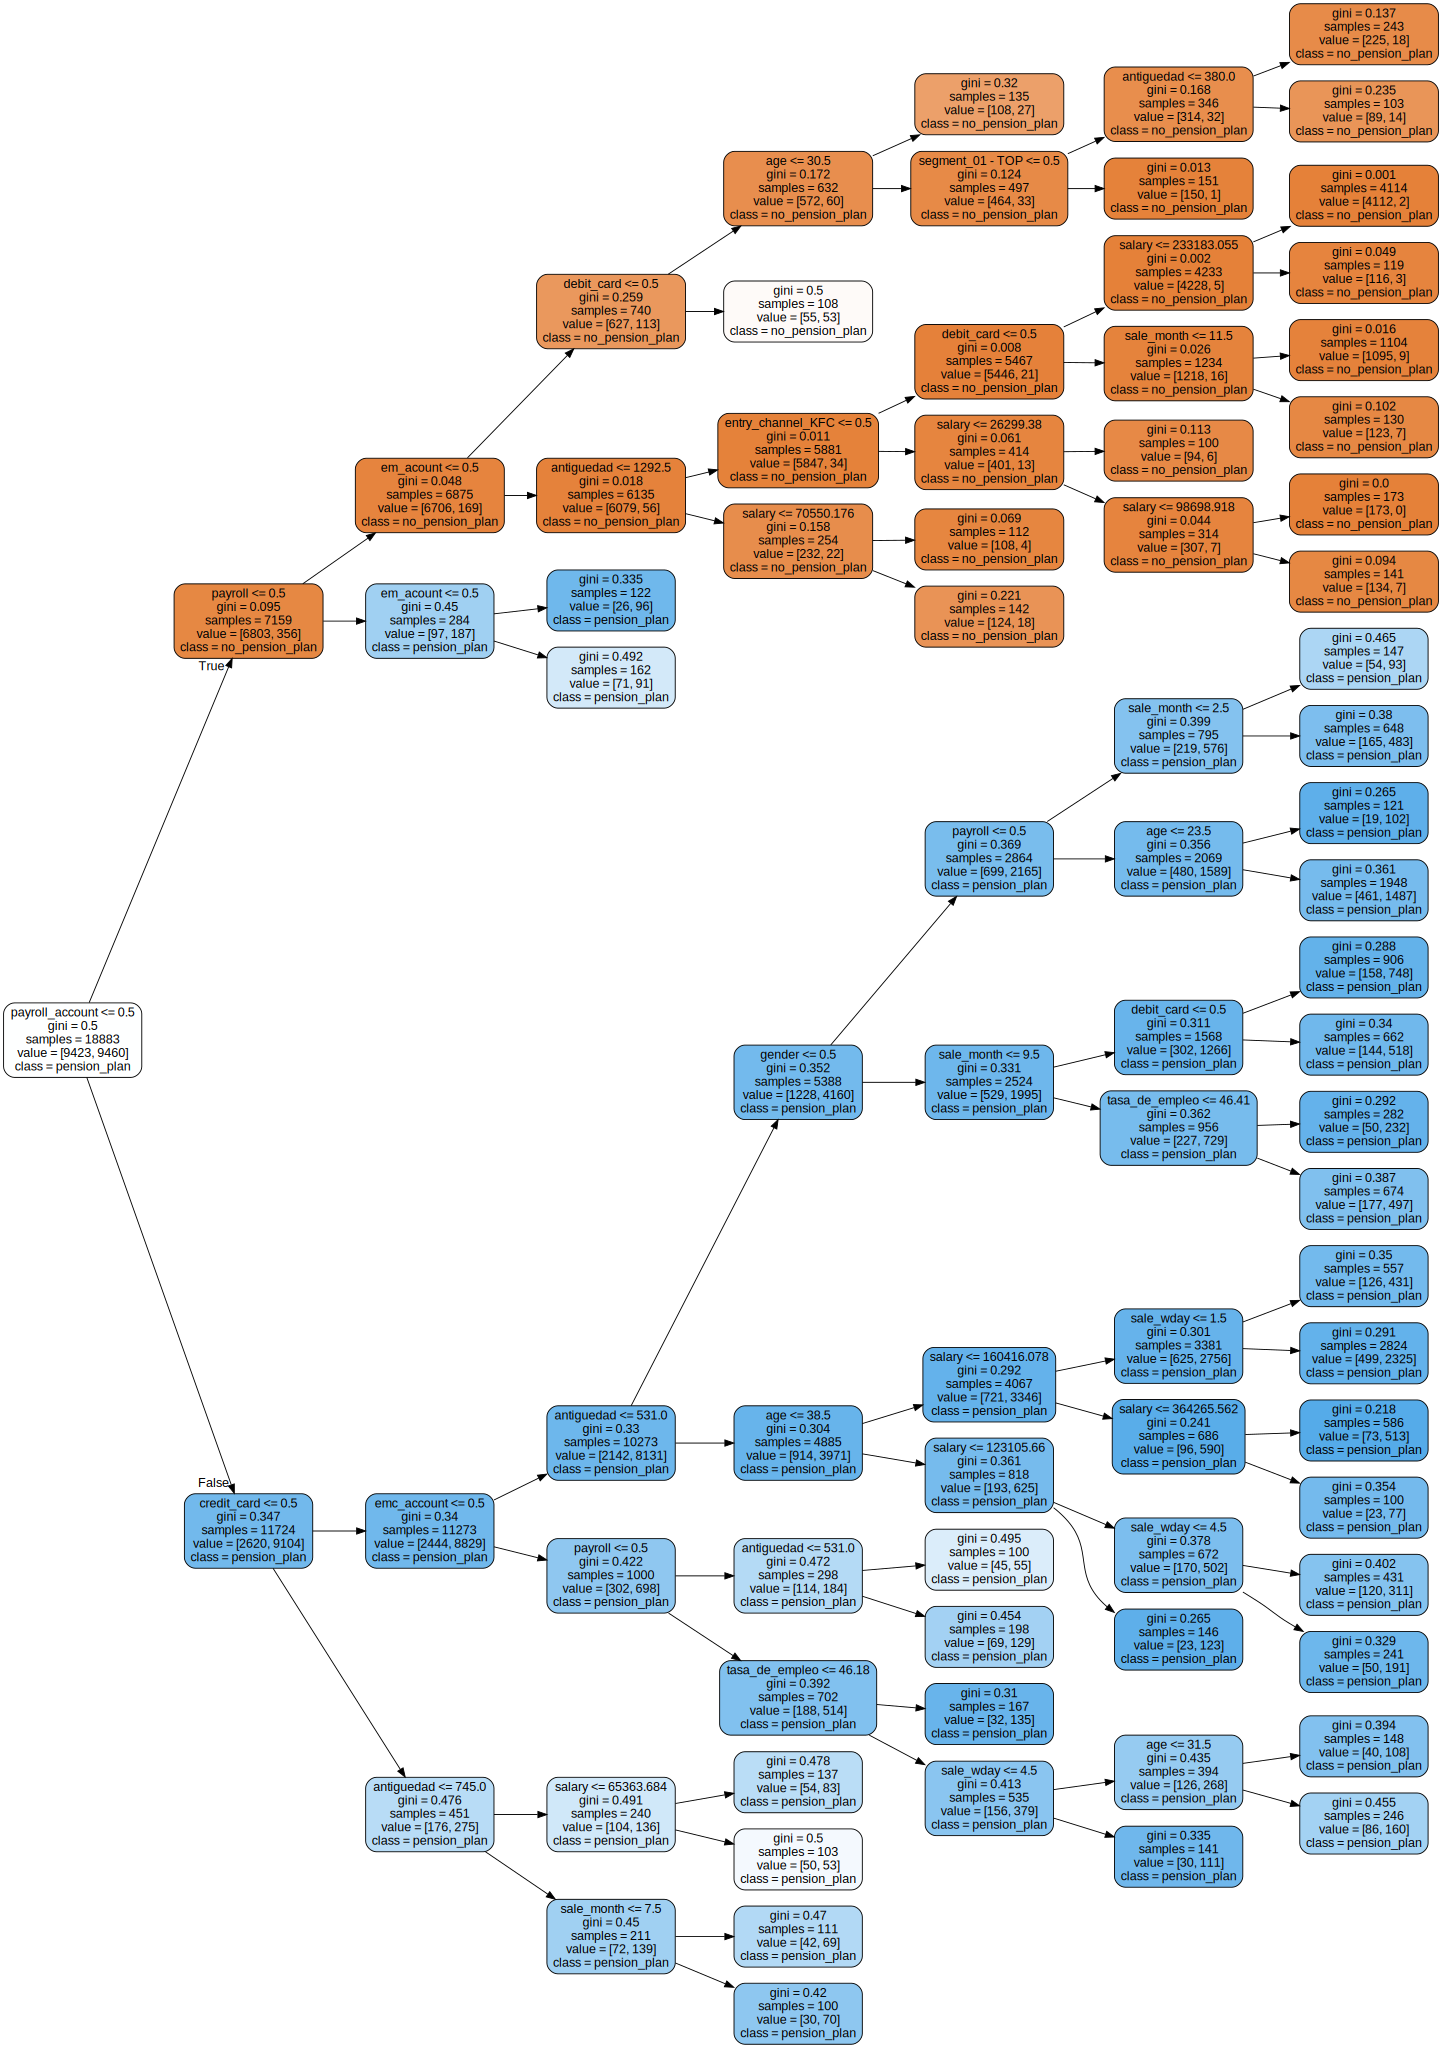

In [69]:
graphviz.Source(tree_data)

In [70]:
#generamos predicciones y evaluamos el modelo
y_test_pred = pd.DataFrame(dt.predict(X_test),index=y_test.index,columns=['pension_plan_prediction'])

In [71]:
#join de y_test y y_test_pred para comparar el resultado real con la predicción
result_df=y_test.join(y_test_pred,how='inner')

In [72]:
result_df['Success']=(result_df['product_ID_1364']==result_df['pension_plan_prediction']).astype(int)

In [73]:
result_df.head()

,product_ID_1364,pension_plan_prediction,Success
customer_ID,,,
35849,0,1,0
37182,0,0,1
43520,0,0,1
79841,0,0,1
92038,0,0,1


In [74]:
dt.score(X_test, y_test)

0.844736284685448

In [75]:
dt.score(val_df_X,val_df_y)
#En validación el resultado es muy malo, acierta un 57.16% de una distribución de 50 que tiene nuestro TARGET

0.6647230320699709

In [ ]:
# El modelo más tonto predicirá con un 50% de accuracy, frente al nuestro que predice con un accuracy 73%

# 0.7108308412430113 con CustomerID en index, sin renta, paro... (si que aportan info de valor)
# 0.7122610843843453 con CustomerID en index, con renta burta y neta, tasa de paro y empleo
# 0.7131712391106488 con CustomerID en index, sin renta neta y tasa paro
# 0.7146014822519828 con max_depth=8 y min_samples_leaf=100

Métricas calidad

In [85]:
def metricas(y_test = y_test, y_test_pred = y_test_pred):
  modelo_tonto = dev_df_y[TARGET].mean()
  acc = metrics.accuracy_score(y_test,y_test_pred)
  precision = metrics.precision_score(y_test,y_test_pred)
  recall = metrics.recall_score(y_test,y_test_pred)
  f1_score = metrics.f1_score(y_test,y_test_pred)

  print(f"Accuracy: {acc}. > El modelo tonto daría: {modelo_tonto}" )
  print(f"Precision: {precision}. > Cuántos positivos de los que detecta realmente lo son")
  print(f"Recall: {recall}. > Cuántos positivos detecta el modelo del total")
  print(f"F1_Score: {f1_score}")

In [86]:
metricas()

Accuracy: 0.844736284685448. > El modelo tonto daría: 0.5
Precision: 0.7702384951293249. > Cuántos positivos de los que detecta realmente lo son
Recall: 0.9790777113578139. > Cuántos positivos detecta el modelo del total
F1_Score: 0.8621921413799586


## AUC y ROC curve

In [87]:
y_score = pd.DataFrame(dt.predict_proba(X_test)[:,1], index=y_test.index, columns=['pension_plan_score']).sort_values(by='pension_plan_score', ascending=False)

In [88]:
result_df = result_df.join(y_score)

In [89]:
result_df.sort_values(by='pension_plan_score', ascending=False).head()

,product_ID_1364,pension_plan_prediction,Success,pension_plan_score
customer_ID,,,,
1321123,1,1,1,0.875427
1132535,1,1,1,0.875427
1131354,1,1,1,0.875427
1349612,1,1,1,0.875427
1126714,1,1,1,0.875427


In [90]:
metrics.roc_auc_score(result_df['product_ID_1364'],result_df['pension_plan_score'])

0.8013493602698598

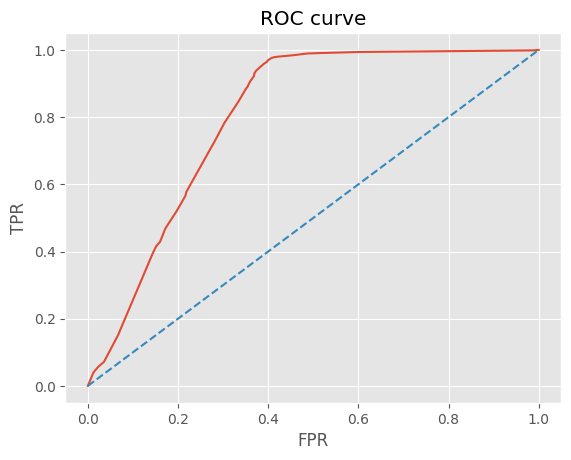

In [91]:
fpr_2,tpr_2,th_2=metrics.roc_curve(result_df['product_ID_1364'],result_df['pension_plan_score'])
plt.plot(fpr_2,tpr_2)
plt.plot([0,1],[0,1],linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

## Control del overfitting Decission Tree

In [92]:
for i in range(1,15):
  #instancio el modelo
  dt2= DecisionTreeClassifier(max_depth=i,random_state=42)
  #entreno el modelo
  dt2.fit(X_train,y_train)
  #evaluo
  acc_train = dt2.score(X_train,y_train)
  acc_test = dt2.score(X_test,y_test)
  print(f'Profundidad de arbol: {i}, Acc.train: {np.round(acc_train,6)},Acc.test: {np.round(acc_test,6)}')

Profundidad de arbol: 1, Acc.train: 0.842398,Acc.test: 0.842618
Profundidad de arbol: 2, Acc.train: 0.847164,Acc.test: 0.844736
Profundidad de arbol: 3, Acc.train: 0.848011,Acc.test: 0.844948
Profundidad de arbol: 4, Acc.train: 0.848276,Acc.test: 0.843889
Profundidad de arbol: 5, Acc.train: 0.850447,Acc.test: 0.844313
Profundidad de arbol: 6, Acc.train: 0.852036,Acc.test: 0.841135
Profundidad de arbol: 7, Acc.train: 0.854207,Acc.test: 0.841983
Profundidad de arbol: 8, Acc.train: 0.856802,Acc.test: 0.83817
Profundidad de arbol: 9, Acc.train: 0.860139,Acc.test: 0.832239
Profundidad de arbol: 10, Acc.train: 0.864428,Acc.test: 0.82885
Profundidad de arbol: 11, Acc.train: 0.867976,Acc.test: 0.826308
Profundidad de arbol: 12, Acc.train: 0.872266,Acc.test: 0.819106
Profundidad de arbol: 13, Acc.train: 0.875444,Acc.test: 0.817412
Profundidad de arbol: 14, Acc.train: 0.879574,Acc.test: 0.81021


In [93]:
#puedo probar con diferent numero de observaciones en el nodo final
for i in range(1,15):
  dt2= DecisionTreeClassifier(max_depth=i,random_state=42,min_samples_split=500)
  dt2.fit(X_train,y_train)
  acc_train = dt2.score(X_train,y_train)
  acc_test = dt2.score(X_test,y_test)


  print(f'Profundidad de arbol: {i}, Acc.train: {np.round(acc_train,6)},Acc.test: {np.round(acc_test,6)}')

Profundidad de arbol: 1, Acc.train: 0.842398,Acc.test: 0.842618
Profundidad de arbol: 2, Acc.train: 0.847164,Acc.test: 0.844736
Profundidad de arbol: 3, Acc.train: 0.847164,Acc.test: 0.844736
Profundidad de arbol: 4, Acc.train: 0.847164,Acc.test: 0.844736
Profundidad de arbol: 5, Acc.train: 0.847694,Acc.test: 0.844313
Profundidad de arbol: 6, Acc.train: 0.847958,Acc.test: 0.844101
Profundidad de arbol: 7, Acc.train: 0.848064,Acc.test: 0.843889
Profundidad de arbol: 8, Acc.train: 0.84817,Acc.test: 0.843465
Profundidad de arbol: 9, Acc.train: 0.848329,Acc.test: 0.843254
Profundidad de arbol: 10, Acc.train: 0.848541,Acc.test: 0.84283
Profundidad de arbol: 11, Acc.train: 0.848594,Acc.test: 0.84283
Profundidad de arbol: 12, Acc.train: 0.848753,Acc.test: 0.841983
Profundidad de arbol: 13, Acc.train: 0.848753,Acc.test: 0.841771
Profundidad de arbol: 14, Acc.train: 0.848859,Acc.test: 0.841771


## Modelos alternativos

### RANDOM FOREST

In [94]:
#Random Forest con 10 replicas
rf_2 = RandomForestClassifier(max_depth=11,random_state=42,min_samples_split=500,n_estimators=12)

In [95]:
rf_2.fit(X_train,y_train)

<ipython-input-95-7bdf2188c4c9>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_2.fit(X_train,y_train)


RandomForestClassifier(max_depth=11, min_samples_split=500, n_estimators=12,
                       random_state=42)

In [96]:
rf_2.score(X_test,y_test)

0.8445244651556874

In [97]:
rf_2.score(val_df_X,val_df_y)
# El resultado en validación empeora un poco respecto a test, aunque tiene un 65,75% de acierto, sobre la distribución del 50% que tiene nuestro TARGET
#Desde luego mejora el simple Decission Tree

0.671957671957672

### XGBOOST (sklearn)

In [98]:
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [99]:
gb = GradientBoostingClassifier(n_estimators=50, max_depth=5, min_samples_split=500, random_state=42)

In [100]:
gb.fit(X_train, np.ravel(y_train))

GradientBoostingClassifier(max_depth=5, min_samples_split=500, n_estimators=50,
                           random_state=42)

In [101]:
gb.score(X_test,y_test)

0.8451599237449693

In [102]:
gb.score(val_df_X,val_df_y)
#En validación el resultado es muy malo, acierta un 58% de una distribución de 50 que tiene nuestro TARGET

0.6718496922578555

### Establecimiento de hiperparámetros óptimos para el GradientBoosting

In [265]:
param_grid = {
    'n_estimators': [20, 50, 70, 100],
    'max_depth': [3, 4, 5, 6, 7, 8]
}

In [266]:
model_gb = GradientBoostingClassifier()

In [ ]:
grid_search = GridSearchCV(estimator=model_gb, param_grid=param_grid, cv=5)
grid_search.fit(X_train, np.ravel(y_train))

In [ ]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [ ]:
print(best_params)
print(best_model)

{'max_depth': 5, 'n_estimators': 50}
GradientBoostingClassifier(max_depth=5, n_estimators=50)


In [ ]:
accuracy = best_model.score(X_test, y_test)
print(accuracy)

0.7454800280308339


## XGBOOST (original)

In [103]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)

In [104]:
params = {
    'max_depth': 6,
    'eta': 0.3,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

# Entrenar el modelo
num_rounds = 100
model_xgb = xgb.train(params, dtrain, num_rounds)

In [105]:
dtest = xgb.DMatrix(data=X_test)

In [106]:
predictions = model_xgb.predict(dtest)

In [107]:
predictions

array([2.1882736e-04, 5.8855140e-01, 1.7316782e-01, ..., 6.1342894e-04,
       8.5470593e-01, 8.0526376e-01], dtype=float32)

In [108]:
from sklearn.metrics import accuracy_score

In [109]:
# Convertir las predicciones a etiquetas binarias (0 o 1)
binary_predictions = [1 if p >= 0.5 else 0 for p in predictions]

In [110]:
# Calcular el accuracy
accuracy = accuracy_score(y_test, binary_predictions)
print("Accuracy:", accuracy)

Accuracy: 0.8326625714890913


In [111]:
dval = xgb.DMatrix(data=val_df_X, label=val_df_y)

In [112]:
val_predictions = model_xgb.predict(dval)

In [113]:
binary_val_predictions = [1 if p >= 0.5 else 0 for p in val_predictions]

In [114]:
val_accuracy = accuracy_score(val_df_y, binary_val_predictions)
print("Validation Accuracy:", val_accuracy)

Validation Accuracy: 0.6880466472303207


## Variables más predictivas

In [115]:
top_features_dt = pd.Series(dt.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(20)

In [116]:
top_features_dt
# Aquí vemos las variables que el modelo Decision Tree ha considerado como más predictivas

payroll_account      0.922764
payroll              0.044576
em_acount            0.006736
debit_card           0.006011
credit_card          0.005127
emc_account          0.003130
antiguedad           0.003054
age                  0.002178
salary               0.001797
sale_month           0.001290
sale_wday            0.001222
tasa_de_empleo       0.001069
gender               0.000627
segment_01 - TOP     0.000305
entry_channel_KFC    0.000115
provincia_Cádiz      0.000000
provincia_Madrid     0.000000
provincia_Lugo       0.000000
provincia_Lleida     0.000000
provincia_León       0.000000
dtype: float64

In [117]:
top_features_2_rd = pd.Series(rf_2.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(20)

In [118]:
top_features_2_rd
# Aquí vemos las variables que el modelo Random Forest ha considerado como más predictivas

payroll_account               0.369493
em_acount                     0.246466
payroll                       0.161732
antiguedad                    0.068186
age                           0.034652
entry_channel_KHQ             0.015514
segment_04 - NO SEGMENT       0.013561
entry_channel_KHE             0.012438
salary                        0.011030
debit_card                    0.010292
sale_month                    0.007029
long_term_deposit             0.006983
emc_account                   0.006148
short_term_deposit            0.005615
segment_01 - TOP              0.004563
sale_wday                     0.002462
segment_03 - UNIVERSITARIO    0.002236
entry_channel_KHM             0.002138
segment_02 - PARTICULARES     0.002060
credit_card                   0.001797
dtype: float64

In [285]:
top_features_2_gb = pd.Series(gb.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(20)

In [286]:
top_features_2_gb
# Aquí vemos las variables que el modelo Gradient Boosting ha considerado como más predictivas

payroll_account       0.897147
payroll               0.044688
em_acount             0.016972
antiguedad            0.006883
debit_card            0.005124
credit_card           0.005071
emc_account           0.004895
age                   0.004848
long_term_deposit     0.002064
sale_month            0.001942
salary                0.001417
segment_01 - TOP      0.001027
tasa_de_empleo        0.000994
short_term_deposit    0.000989
sale_wday             0.000661
securities            0.000591
sale_year             0.000564
renta_bruta_media     0.000469
entry_channel_KHE     0.000278
provincia_Madrid      0.000275
dtype: float64

## Comparación entre modelos

In [119]:
RANDOM_STATE = 42
n_estimators = 50
max_depth = 8

models = [
    ('DecisionTree', DecisionTreeClassifier(max_depth=max_depth, random_state=42)),
    ('RandomForest', RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=RANDOM_STATE)),
    ('GradientBoosting', GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=RANDOM_STATE))
]

ROC AUC Score for DecisionTree: 0.8548734855835415
ROC AUC Score for RandomForest: 0.867451519468851
ROC AUC Score for GradientBoosting: 0.85001789426339


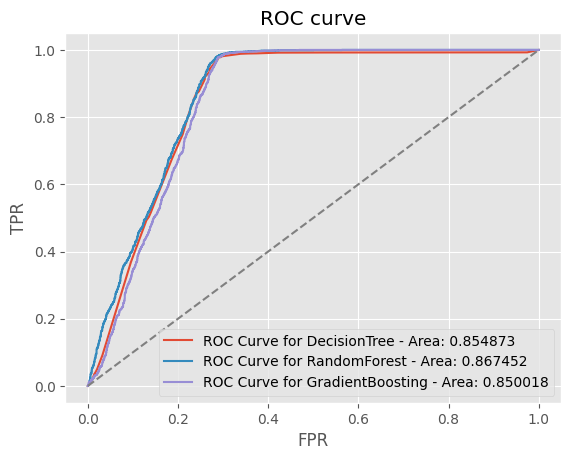

In [120]:
plt.clf()
for model in models:
    model_name = model[0]
    model_instance = model[1]
    model_instance.fit(X_train, np.ravel(y_train))
    predictions = model_instance.predict_proba(X_test)[:,1]
    auc_score = metrics.roc_auc_score(y_test, predictions)
    print('ROC AUC Score for {}: {}'.format(model_name, auc_score))
    fpr, tpr, _ = metrics.roc_curve(y_test, predictions)
    plt.plot(fpr, tpr, label='ROC Curve for {} - Area: {:2f}'.format(model_name, auc_score))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc="lower right")
plt.title('ROC curve')
plt.show()

In [ ]:
# SIGUIENTES PASOS

# --> Métricas y evaluación de métricas del random forest

# --> Acordar dos target más (me parecen buena opción la debit_card y la cuenta emc_account)
# Se me ocurre como estrategia de marketing ofrecer el pack plan de pensiones + emc_account a ambos grupos de clientes potenciales para diversificar riesgo,
# teniendo algo muy seguro y largoplazista y otra inversión más especulativa (se apoya esta estrategia en que el grueso de los clientes son gente joven a la que puede interesar el mix)
# --> Adaptar el dataset2 y dataset3 para lanzar los modelos sobre el target2 y target3

## PIVOT TABLE DEV, VAL

In [ ]:
#elegimos las varibales más predictivas en todos los modelos
#payroll_account
#payroll
#em_acount
#antiguedad
#age



In [289]:
df_final.head()

,antiguedad,gender,age,salary,renta_bruta_media,tasa_de_empleo,short_term_deposit,loans,mortgage,funds,...,provincia_Sevilla,provincia_Soria,provincia_Tarragona,provincia_Teruel,provincia_Toledo,provincia_Valencia/València,provincia_Valladolid,provincia_Zamora,provincia_Zaragoza,provincia_Ávila
customer_ID,,,,,,,,,,,,,,,,,,,,,
33620,395.0,1,50.0,138618.57,15183.0,53.60,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
35063,395.0,1,62.0,125530.41,15183.0,53.60,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
37299,485.0,0,54.0,0.00,14028.0,50.22,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
39997,485.0,0,62.0,201575.01,14550.0,43.28,1.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
44012,485.0,0,42.0,97601.04,15183.0,53.60,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [291]:
df_final.columns

Index(['antiguedad', 'gender', 'age', 'salary', 'renta_bruta_media',
       'tasa_de_empleo', 'short_term_deposit', 'loans', 'mortgage', 'funds',
       'securities', 'long_term_deposit', 'credit_card', 'payroll',
       'payroll_account', 'emc_account', 'debit_card', 'em_acount',
       'sale_month', 'sale_year', 'sale_wday', 'sale_day', 'product_ID_1364',
       'entry_channel_KHE', 'entry_channel_KFC', 'entry_channel_KAT',
       'entry_channel_KHQ', 'entry_channel_KHK', 'entry_channel_KHM',
       'entry_channel_KHN', 'entry_channel_KFA', 'entry_channel_RED',
       'entry_channel_KHL', 'entry_channel_KHD', 'entry_channel_KHO',
       'entry_channel_OTHERS', 'segment_01 - TOP', 'segment_02 - PARTICULARES',
       'segment_03 - UNIVERSITARIO', 'segment_04 - NO SEGMENT',
       'country_id_ES', 'provincia_Albacete', 'provincia_Alicante/Alacant',
       'provincia_Almería', 'provincia_Araba/Álava', 'provincia_Asturias',
       'provincia_Badajoz', 'provincia_Balears, Illes', 'provinci

In [6]:
pd.pivot_table?


In [83]:
pivot_table= pd.pivot_table(df_final,columns=['sale_month','sale_year'], values=['payroll_account','payroll','em_acount','antiguedad','age','debit_card','salary'],aggfunc='mean')


In [84]:
pivot_table

sale_month                 1             2                            3   \
sale_year                2019          2018          2019           2018   
age                 38.144467     37.594442     38.253853      38.366780   
antiguedad         362.903628    814.269205    354.355186     713.543438   
debit_card           0.348571      0.465986      0.421979       0.387603   
em_acount            0.588494      0.498696      0.547669       0.548765   
payroll              0.246519      0.348931      0.302188       0.280291   
payroll_account      0.344082      0.439535      0.398478       0.384504   
salary           39521.202298  97515.898543  36368.140399  100229.359973   

sale_month                                4                           5   \
sale_year                2019           2018          2019          2018   
age                 37.843377      38.611723     37.322211     38.797162   
antiguedad         326.717671     670.367673    324.849260    635.434621   
debit_card           0.410719       0.370428      0.400713      0.355220   
em_acount            0.544293       0.520714      0.503617      0.526974   
payroll              0.301305       0.290106      0.336789      0.297781   
payroll_account      0.403221       0.408881      0.439369      0.390134   
salary           33309.513260  101772.772566  33535.514869  99745.847063   

sale_month                  6              7             8             9   \
sale_year                 2018           2018          2018          2018   
age                  37.413150      31.939618     30.905697     32.510345   
antiguedad          677.187770     539.038681    472.436634    429.335003   
debit_card            0.360158       0.241198      0.225347      0.250000   
em_acount             0.556087       0.615420      0.680549      0.712309   
payroll               0.296380       0.227037      0.188806      0.162691   
payroll_account       0.377790       0.336524      0.269182      0.226015   
salary           100396.461663  102659.247128  89708.285356  83101.053048   

sale_month                 10            11            12  
sale_year                2018          2018          2018  
age                 33.211819     35.301211     37.034456  
antiguedad         437.009035    430.814208    466.783941  
debit_card           0.306993      0.356373      0.357629  
em_acount            0.668317      0.569709      0.520361  
payroll              0.210025      0.286959      0.237451  
payroll_account      0.274257      0.375055      0.430132  
salary           48831.176818  50444.906628  52305.325233